# Deep Convolutional Generative Adversarial Networks

In this notebook, I will show how to train a DCGAN system to generate realistic MNIST digits at 64x64 resolution. 

## Imports

In [1]:
from os.path import exists, join, dirname, basename
import os
import time
from glob import glob

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from PIL import Image
import scipy

import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.tensorboard.plugins import projector

## Utils

### MNIST data handler

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


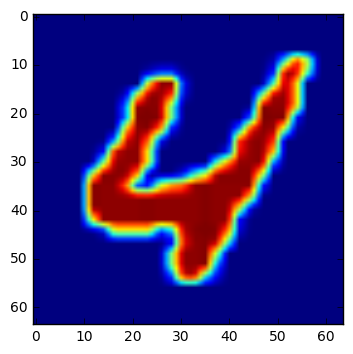

In [2]:
class MNIST_Generator(object):

    def __init__(self):

        # Download data if needed
        self.mnist = input_data.read_data_sets("./MNIST_data/", one_hot=False)
        self.n_train_images = self.mnist.train.images.shape[0]
        self.n_validation_images = self.mnist.validation.images.shape[0]

    def get_batch(self, batch_size):

        idx = np.random.choice(self.n_train_images, batch_size)
        batch = self.mnist.train.images[idx, :].reshape((batch_size, 28, 28))
        batch_resized = []
        for i in range(batch.shape[0]):
            batch_resized.append(scipy.ndimage.zoom(batch[i, :, :], 2.3, order=1))  # resize to 64x64 pixels
        batch = np.stack(batch_resized)
        batch = batch[:, :, :, np.newaxis]  # channel dimension
        batch = batch*2 - 1  # [-1, 1] range tanh
        return batch.astype('float32')

# Test
mnist_gen_test = MNIST_Generator()
batch = mnist_gen_test.get_batch(8)
plt.imshow(batch[0, :, :, 0])

### Random generator for Z

In [3]:
class Z_Generator(object):

    def __init__(self, size):
        self.size = size

    def get_batch(self, batch_size):
        return np.random.uniform(-1, 1, [batch_size, self.size]).astype(np.float32)

# Test
z_gen_test = Z_Generator(100)
batch = z_gen_test.get_batch(8)
print(batch[0, :])

[-0.83167315 -0.4762772   0.8410961   0.63781714  0.25057316 -0.37691277
 -0.23075841  0.39496893 -0.73199564 -0.35092467  0.26063809  0.18342601
  0.28650585  0.65318877 -0.26428953 -0.66003567 -0.33322293 -0.41684404
  0.15833186 -0.7791639  -0.44241285 -0.49494547 -0.77712101 -0.45774895
  0.3925114   0.91651475  0.24007405 -0.68870348 -0.59267133 -0.82992482
 -0.27008203  0.6457597   0.28725588  0.98120958  0.26141518 -0.30864161
 -0.081424    0.37384617 -0.46819502 -0.96639866  0.66861784 -0.14662094
  0.42379871 -0.50772536  0.89429945  0.45278278 -0.2657024  -0.12556195
  0.6357497  -0.64548105  0.29322439  0.91503751 -0.81875461  0.99251467
 -0.3530021  -0.04544213  0.40316376 -0.83788776  0.50764936  0.40513188
 -0.74725509 -0.58202302 -0.61845201 -0.78983289  0.01471467  0.82535517
  0.75735664  0.30959082  0.69639224  0.33127433  0.92029572 -0.41960016
  0.28036287 -0.20905241  0.28414601  0.56053871 -0.12571856  0.75860047
  0.12462631  0.99883914  0.54998183 -0.61716104 -0

### Tensorboard handler

In [4]:
class TensorboardHandler(object):

    def __init__(self, output_dir):

        # Create dir
        if not exists(output_dir):
            os.makedirs(output_dir)
        self.output_dir = output_dir

        # Writer
        self.tensorboard_writer = tf.summary.FileWriter(
            logdir=output_dir, graph=tf.get_default_graph())

        # Variables
        self.variables = {}

    def register_variable(self, tag, type='variable'):

        if tag not in self.variables.keys():
            self.variables[tag] = {}
            self.variables[tag]['placeholder'] = tf.placeholder(dtype=tf.float32, name='%s_holder' % tag)

            if type == 'histogram':
                self.variables[tag]['summary'] = tf.summary.histogram(tag, self.variables[tag]['placeholder'])
            elif type == 'image':
                self.variables[tag]['summary'] = tf.summary.image(tag, self.variables[tag]['placeholder'])
            else:
                self.variables[tag]['summary'] = tf.summary.scalar(tag, self.variables[tag]['placeholder'])

        else:
            print('Cannot register variable because it already exists.')

    def write(self, session, tag, value, episode_number):

        self.tensorboard_writer.add_summary(
            session.run(self.variables[tag]['summary'], feed_dict={self.variables[tag]['placeholder']: value}), episode_number)

    def write_weights(self, session, weights, episode_number):

        self.tensorboard_writer.add_summary(
            session.run(weights),
            episode_number
        )

    def flush(self):
        self.tensorboard_writer.flush()

### Plot images on a grid

In [5]:
def plot(x_list, output_path, n_grid, m_pixels, margin=2, show=False):

    from PIL import Image

    image_canvas = Image.new("L", (n_grid*(m_pixels+margin), n_grid*(m_pixels+margin)))
    i = 0

    for x_bias in range(n_grid):
        for y_bias in range(n_grid):
            image_array = 1.0 * (x_list[i][:, :, :].reshape(m_pixels, m_pixels) + 1) / 2.0
            image_array = np.uint8(image_array * 255.0)
            image = Image.fromarray(image_array)
            image_canvas.paste(image, (x_bias*(m_pixels+margin), y_bias*(m_pixels+margin)))
            i += 1

    image_canvas = image_canvas.resize((600, 600), Image.NEAREST)
    image_canvas.save(output_path)
    if show:
        plt.imshow(np.asarray(image_canvas), cmap='gray')
        plt.show()


### Others

In [6]:
def lrelu(x, leak=0.2):
    return tf.maximum(x, leak * x)

## DCGAN

In [7]:
class DCGAN_network():

    def __init__(self, z_size, g_size):

        # Parameters
        self.z_size = z_size
        self.g_size = g_size

        # Placeholders
        self.learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate_holder')
        self.z = tf.placeholder(shape=[None, self.z_size], dtype=tf.float32, name='z_holder')
        self.x = tf.placeholder(shape=[None, self.g_size, self.g_size, 1], dtype=tf.float32, name='x_holder')

        # Network
        self.g = self.generator_network(self.z, scope='generator')  # fake data
        self.score_real_logit, self.score_real, self.embedding = self.discriminator_network(self.x, scope='discriminator')  # prob of data to be real (should be one)
        self.score_fake_logit, self.score_fake, _ = self.discriminator_network(self.g, scope='discriminator', re_use=True)  # prob of fake data to be real (should be zero)

        # Loss
        self.loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(self.score_fake_logit, tf.zeros_like(self.score_fake)), name='loss_discriminator_fake')
        self.loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(self.score_real_logit, tf.ones_like(self.score_real)), name='loss_discriminator_real')
        self.loss_dis = tf.add(self.loss_fake, self.loss_real, name='loss_discriminator')
        self.loss_gen = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(self.score_fake_logit, tf.ones_like(self.score_fake)), name='loss_generator')  # generator wants fake probs to be ones

        # Updates
        trainable_variables = tf.trainable_variables()
        discriminator_variables = [var for var in trainable_variables if 'discriminator' in var.name]
        generator_variables = [var for var in trainable_variables if 'generator' in var.name]

        self.update_discriminator = \
            tf.train.AdamOptimizer(self.learning_rate, name='adam_discriminator').minimize(self.loss_dis, var_list=discriminator_variables)
        self.update_generator = \
            tf.train.AdamOptimizer(self.learning_rate, name='adam_generator').minimize(self.loss_gen, var_list=generator_variables)

        # Tensorboard
        hist_list = []
        for var in slim.get_variables():
            parts = var.name.split(':')[0].split('/')
            tag = parts[0]
            if (len(parts) == 3) and ((tag == 'discriminator') or (tag == 'generator')):
                name = parts[1]
                function = parts[2]
                if (function == 'weights'):
                    hist_list.append(tf.summary.histogram(var.name, var.value()))
        self.tensor_board_merged = tf.summary.merge(hist_list)

    def generator_network(self, input, scope):

        with tf.variable_scope(scope):

            network = slim.fully_connected(input, 1024 * 4 * 4, normalizer_fn=slim.batch_norm, activation_fn=tf.nn.relu, scope='0_lin')
            network = tf.reshape(network, [-1, 4, 4, 1024], name='1_lin_reshaped')
            network = slim.conv2d_transpose(network, 512, 3, stride=2, normalizer_fn=slim.batch_norm, activation_fn=tf.nn.relu, scope='2_deconv')
            network = slim.conv2d_transpose(network, 256, 3, stride=2, normalizer_fn=slim.batch_norm, activation_fn=tf.nn.relu, scope='3_deconv')
            network = slim.conv2d_transpose(network, 128, 3, stride=2, normalizer_fn=slim.batch_norm, activation_fn=tf.nn.relu, scope='4_deconv')
            output = slim.conv2d_transpose(network, 1, 3, stride=2, activation_fn=tf.nn.tanh, scope='5_deconv')

            return output

    def discriminator_network(self, input, scope, re_use=False):

        with tf.variable_scope(scope) as s:
            if re_use:
                # use the same graph
                s.reuse_variables()

            network = slim.conv2d(input, 64, 3, stride=2, scope='0_conv', activation_fn=lrelu)
            network = slim.conv2d(network, 128, 3, stride=2, normalizer_fn=slim.batch_norm, activation_fn=lrelu, scope='1_conv')
            network = slim.conv2d(network, 256, 3, stride=2, normalizer_fn=slim.batch_norm, activation_fn=lrelu, scope='2_conv')
            network = slim.conv2d(network, 512, 3, stride=2, normalizer_fn=slim.batch_norm, activation_fn=lrelu, scope='3_conv')
            embedding = slim.flatten(network, scope='4_embedding')
            output_logits = slim.fully_connected(embedding, 1, activation_fn=None, scope='5_output_logits')  # no BN here!!!
            output = tf.nn.sigmoid(output_logits, name='6_output')

            return output_logits, output, embedding

    def generator_backward_pass(self, session, z, learning_rate):

        # Update model
        _, loss_gen, g = session.run([self.update_generator, self.loss_gen, self.g], feed_dict={
            self.learning_rate: learning_rate,
            self.z: z
        })

        return loss_gen, g

    def discriminator_backward_pass(self, session, z, x, learning_rate):

        # Update model
        _, loss_fake, loss_real, score_fake, score_real = session.run(
            [self.update_discriminator, self.loss_fake, self.loss_real, self.score_fake, self.score_real],
            feed_dict={
                self.learning_rate: learning_rate,
                self.x: x,
                self.z: z
            }
        )

        return loss_fake, loss_real, score_fake, score_real

    def discriminator_embedding(self, session, x):

        # Get embedding
        embedding_value = session.run(
            self.embedding,
            feed_dict={
                self.x: x
            }
        )
        return embedding_value

    def generator_forward(self, session, z):

        g = session.run(
            self.g,
            feed_dict={
                self.z: z
            }
        )
        return g

    def get_weights_tensorboard(self):
        return self.tensor_board_merged

## Training

In [8]:
def train_dcgan_mnist64(output_dir, learning_rate_0, learning_rate_end, batch_size, n_epochs, iterations_per_epoch, z_size, 
         g_size, update_discriminator_times, update_generator_times, load_model_path):

    # Reset tensorflow
    tf.reset_default_graph()

    # Initialize
    data_provider = MNIST_Generator()
    z_provider = Z_Generator(size=z_size)
    gan_network = DCGAN_network(z_size=z_size, g_size=g_size)
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    learning_rates = np.logspace(learning_rate_0, learning_rate_end, iterations_per_epoch * n_epochs)
    counter = 0

    # Force GPU / CPU
    config = tf.ConfigProto(
        # device_count={'GPU': 0}  # uncomment this line to use CPU
    )

    # Launch the tensorflow graph
    with tf.Session(config=config) as sess:

        # Start session
        sess.run(init)

        # Load checkpoint
        if load_model_path is not None:
            print('Checkpoint loaded')
            checkpoint = tf.train.get_checkpoint_state(load_model_path)
            saver.restore(sess, checkpoint.model_checkpoint_path)

        # Tensorboard registration
        run_id = time.strftime("%Y%m%d%H%M%S", time.gmtime())
        summaries_dir = join(output_dir, run_id)
        if not exists(summaries_dir):
            os.makedirs(summaries_dir)
        tb = TensorboardHandler(summaries_dir)
        with tf.variable_scope('tier1'):
            tb.register_variable('loss_fake')
            tb.register_variable('loss_real')
            tb.register_variable('loss_gen')
        with tf.variable_scope('tier2'):
            tb.register_variable('learning_rate')
        with tf.variable_scope('activations'):
            tb.register_variable('score_fake', 'histogram')
            tb.register_variable('score_real', 'histogram')
        with tf.variable_scope('images'):
            tb.register_variable('generator', 'image')
            tb.register_variable('real', 'image')

        # Run epochs
        for epoch in range(n_epochs):

            # Run through samples
            loss_fake_v = []
            loss_real_v = []
            loss_gen_v = []

            # Run iterations per epoch
            for iteration in range(iterations_per_epoch):

                for _ in range(update_discriminator_times):
                    # Get data and z
                    mini_batch_x = data_provider.get_batch(int(batch_size/2))
                    mini_batch_z = z_provider.get_batch(int(batch_size/2))

                    # Update discriminator
                    loss_fake, loss_real, score_fake, score_real = gan_network.discriminator_backward_pass(
                            session=sess, z=mini_batch_z, x=mini_batch_x, learning_rate=learning_rates[counter])

                for _ in range(update_generator_times):
                    # Get data and z
                    mini_batch_z = z_provider.get_batch(batch_size)

                    # Update generator
                    loss_gen, g = gan_network.generator_backward_pass(
                            session=sess, z=mini_batch_z, learning_rate=learning_rates[counter])

                loss_fake_v.append(loss_fake)
                loss_real_v.append(loss_real)
                loss_gen_v.append(loss_gen)

                # Write to tensorboard
                tb.write(sess, 'loss_fake', loss_fake, counter)
                tb.write(sess, 'loss_real', loss_real, counter)
                tb.write(sess, 'loss_gen', loss_gen, counter)
                tb.write(sess, 'score_fake', score_fake, counter)
                tb.write(sess, 'score_real', score_real, counter)
                tb.write(sess, 'learning_rate', learning_rates[counter], counter)
                tb.write_weights(sess, gan_network.get_weights_tensorboard(), counter)
                counter += 1

            print('[Epoch %03d] learning_rate: %0.6f, loss_fake: %0.3f, loss_real: %0.3f, loss_gen: %0.3f'
                  %(epoch, learning_rates[counter-1], np.mean(loss_fake_v), np.mean(loss_real_v), np.mean(loss_gen_v)))

            # Write images to tensorboard
            tb.write(sess, 'generator', g, counter)
            tb.write(sess, 'real', mini_batch_x, counter)
            tb.flush()

            # Save parameters
            saver.save(sess, join(summaries_dir, 'checkpoint_episode_%d.sav' % epoch))

            # Plot real and artificially generated images
            plot_dir = join(summaries_dir, 'plots')
            if not exists(plot_dir):
                os.mkdir(plot_dir)
            if epoch == 0:
                plot(mini_batch_x, join(plot_dir, 'epoch_%04d_x.png' % epoch), n_grid=5, m_pixels=g_size)
            plot(g, join(plot_dir, 'epoch_%04d_g.png' % epoch), n_grid=5, m_pixels=g_size, show=True)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Summary name generator/0_lin/weights:0 is illegal; using generator/0_lin/weights_0 instead.
INFO:tensorflow:Summary name generator/2_deconv/weights:0 is illegal; using generator/2_deconv/weights_0 instead.
INFO:tensorflow:Summary name generator/3_deconv/weights:0 is illegal; using generator/3_deconv/weights_0 instead.
INFO:tensorflow:Summary name generator/4_deconv/weights:0 is illegal; using generator/4_deconv/weights_0 instead.
INFO:tensorflow:Summary name generator/5_deconv/weights:0 is illegal; using generator/5_deconv/weights_0 instead.
INFO:tensorflow:Summary name discriminator/0_conv/weights:0 is illegal; using discriminator/0_conv/weights_0 instead.
INFO:tensorflow:Summary name discriminator/1_conv/weights:0 is illegal; using discriminator/1_conv/weights_0 instead

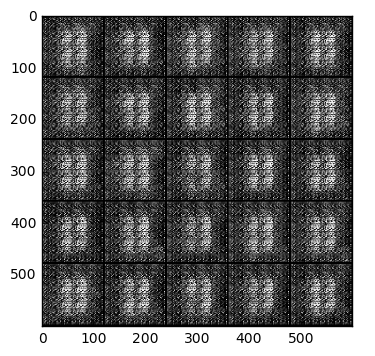

[Epoch 001] learning_rate: 0.000295, loss_fake: 0.719, loss_real: 0.992, loss_gen: 1.778


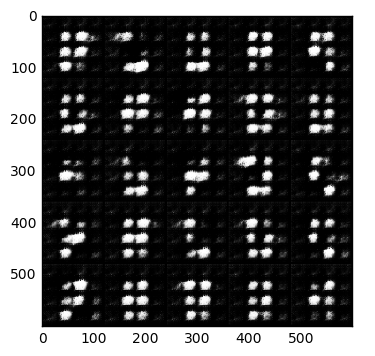

[Epoch 002] learning_rate: 0.000285, loss_fake: 0.914, loss_real: 1.419, loss_gen: 1.222


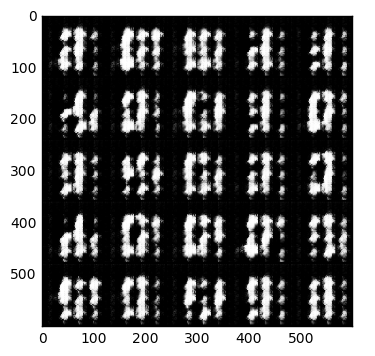

[Epoch 003] learning_rate: 0.000276, loss_fake: 0.824, loss_real: 1.373, loss_gen: 1.159


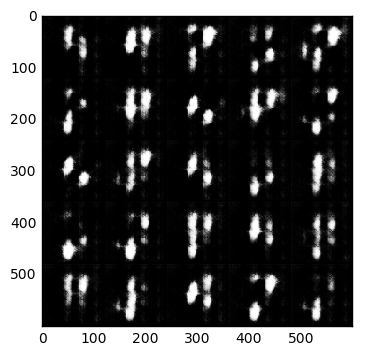

[Epoch 004] learning_rate: 0.000266, loss_fake: 0.652, loss_real: 0.808, loss_gen: 1.339


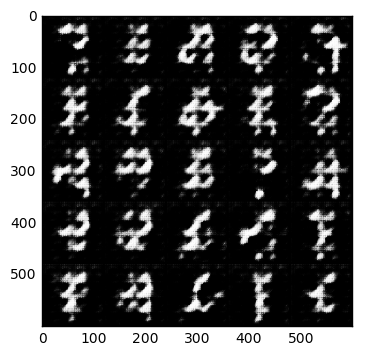

[Epoch 005] learning_rate: 0.000257, loss_fake: 0.694, loss_real: 0.882, loss_gen: 1.227


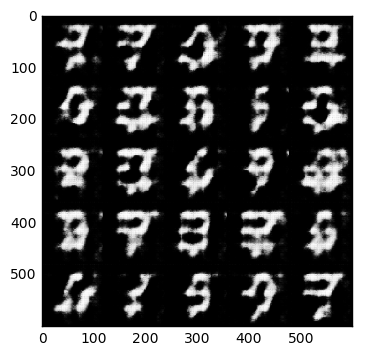

[Epoch 006] learning_rate: 0.000248, loss_fake: 0.719, loss_real: 0.827, loss_gen: 1.117


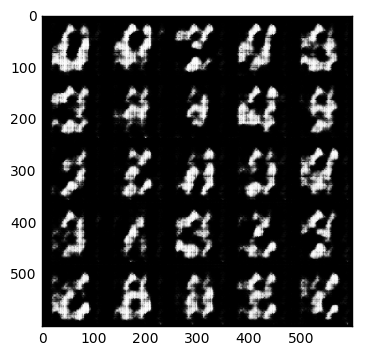

[Epoch 007] learning_rate: 0.000240, loss_fake: 0.692, loss_real: 0.864, loss_gen: 1.091


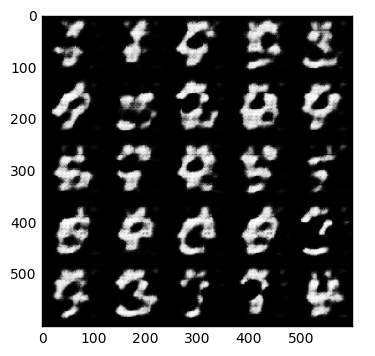

[Epoch 008] learning_rate: 0.000232, loss_fake: 0.744, loss_real: 0.821, loss_gen: 0.920


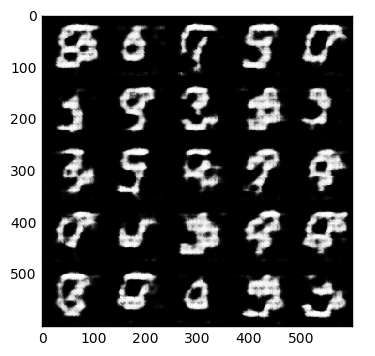

[Epoch 009] learning_rate: 0.000224, loss_fake: 0.624, loss_real: 0.675, loss_gen: 1.006


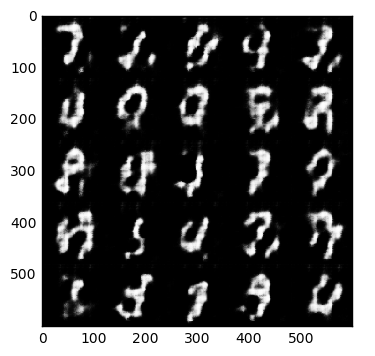

[Epoch 010] learning_rate: 0.000216, loss_fake: 0.609, loss_real: 0.632, loss_gen: 1.070


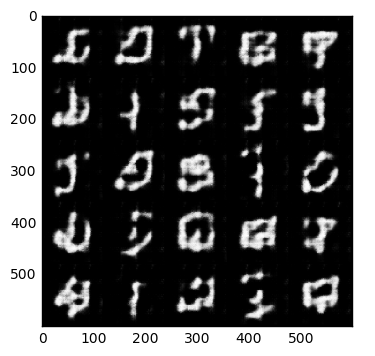

[Epoch 011] learning_rate: 0.000209, loss_fake: 0.663, loss_real: 0.720, loss_gen: 1.043


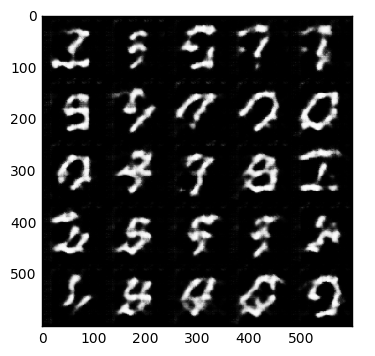

[Epoch 012] learning_rate: 0.000202, loss_fake: 0.704, loss_real: 0.756, loss_gen: 0.906


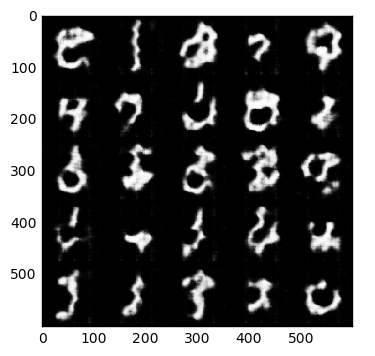

[Epoch 013] learning_rate: 0.000195, loss_fake: 0.643, loss_real: 0.693, loss_gen: 0.936


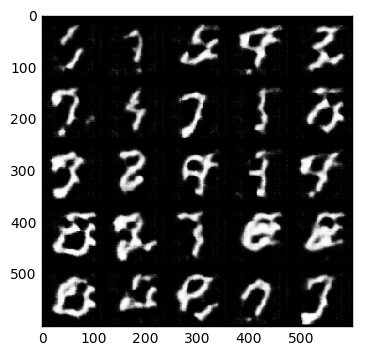

[Epoch 014] learning_rate: 0.000188, loss_fake: 0.766, loss_real: 0.812, loss_gen: 0.831


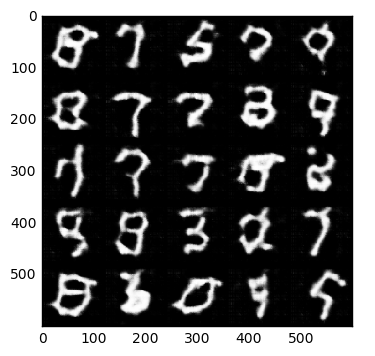

[Epoch 015] learning_rate: 0.000182, loss_fake: 0.727, loss_real: 0.748, loss_gen: 0.799


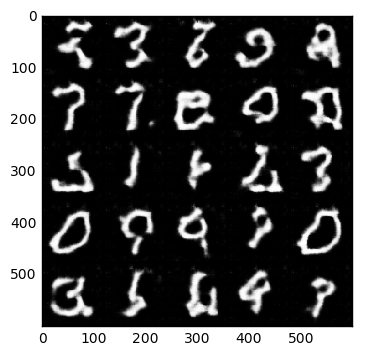

[Epoch 016] learning_rate: 0.000176, loss_fake: 0.675, loss_real: 0.706, loss_gen: 0.826


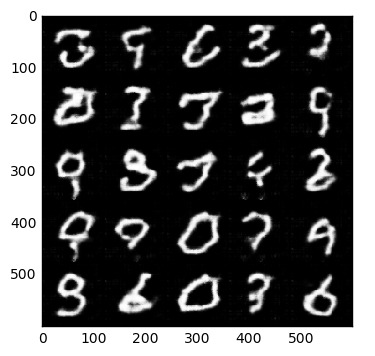

[Epoch 017] learning_rate: 0.000170, loss_fake: 0.707, loss_real: 0.712, loss_gen: 0.791


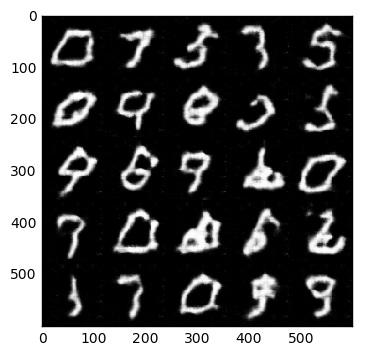

[Epoch 018] learning_rate: 0.000164, loss_fake: 0.674, loss_real: 0.705, loss_gen: 0.782


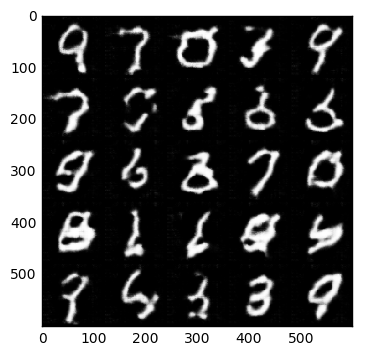

[Epoch 019] learning_rate: 0.000159, loss_fake: 0.649, loss_real: 0.665, loss_gen: 0.844


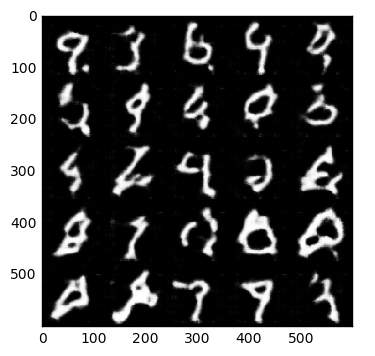

[Epoch 020] learning_rate: 0.000153, loss_fake: 0.697, loss_real: 0.718, loss_gen: 0.813


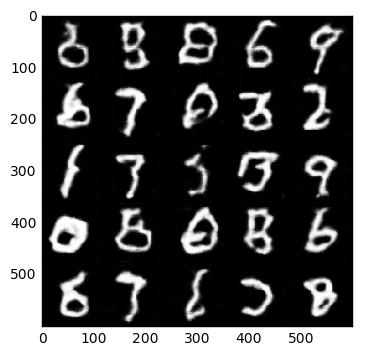

[Epoch 021] learning_rate: 0.000148, loss_fake: 0.697, loss_real: 0.704, loss_gen: 0.814


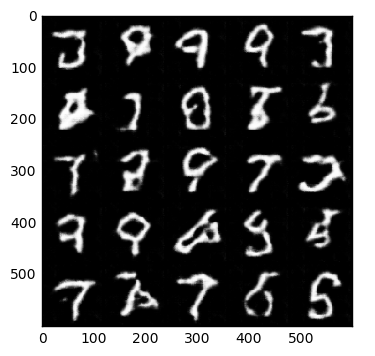

[Epoch 022] learning_rate: 0.000143, loss_fake: 0.718, loss_real: 0.729, loss_gen: 0.774


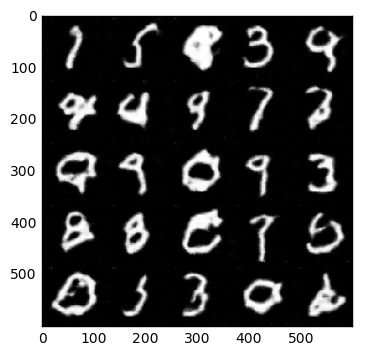

[Epoch 023] learning_rate: 0.000138, loss_fake: 0.676, loss_real: 0.709, loss_gen: 0.793


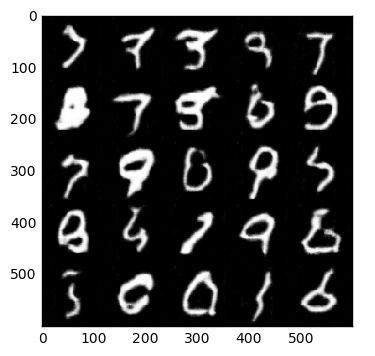

[Epoch 024] learning_rate: 0.000133, loss_fake: 0.731, loss_real: 0.721, loss_gen: 0.753


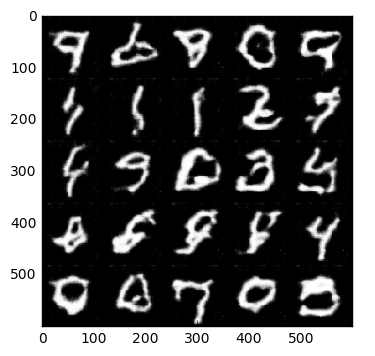

[Epoch 025] learning_rate: 0.000129, loss_fake: 0.692, loss_real: 0.705, loss_gen: 0.765


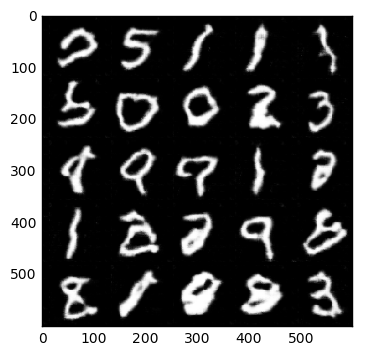

[Epoch 026] learning_rate: 0.000125, loss_fake: 0.698, loss_real: 0.699, loss_gen: 0.778


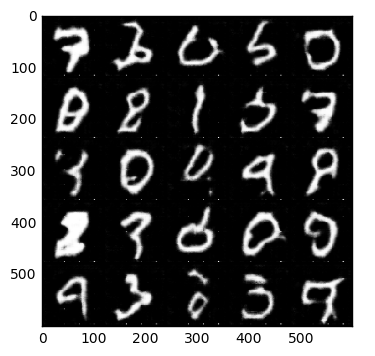

[Epoch 027] learning_rate: 0.000120, loss_fake: 0.701, loss_real: 0.719, loss_gen: 0.754


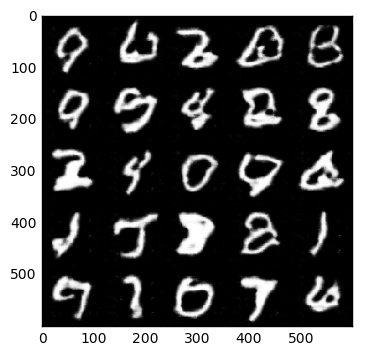

[Epoch 028] learning_rate: 0.000116, loss_fake: 0.677, loss_real: 0.680, loss_gen: 0.753


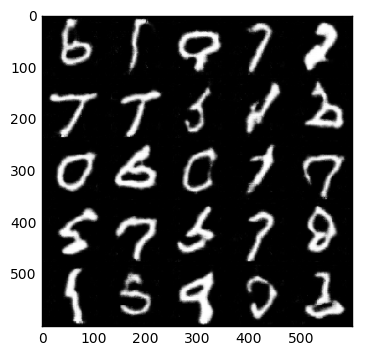

[Epoch 029] learning_rate: 0.000112, loss_fake: 0.668, loss_real: 0.678, loss_gen: 0.774


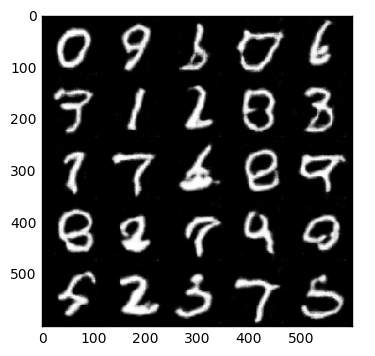

[Epoch 030] learning_rate: 0.000108, loss_fake: 0.673, loss_real: 0.685, loss_gen: 0.748


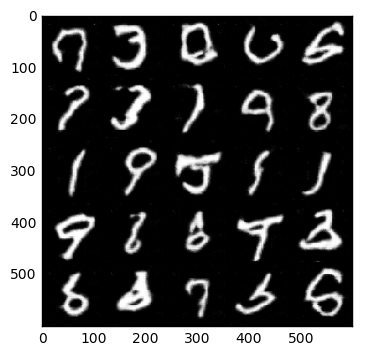

[Epoch 031] learning_rate: 0.000105, loss_fake: 0.665, loss_real: 0.668, loss_gen: 0.776


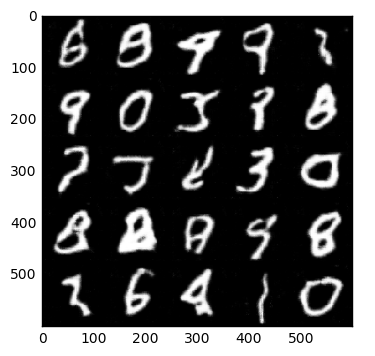

[Epoch 032] learning_rate: 0.000101, loss_fake: 0.669, loss_real: 0.680, loss_gen: 0.760


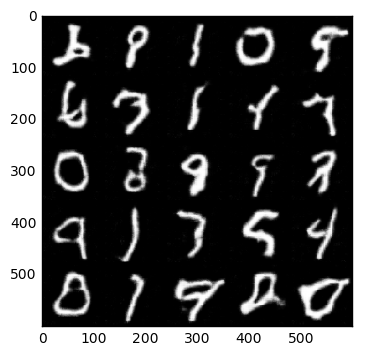

[Epoch 033] learning_rate: 0.000098, loss_fake: 0.678, loss_real: 0.677, loss_gen: 0.749


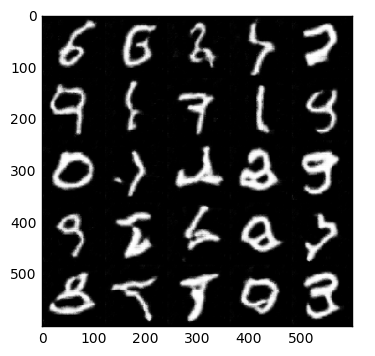

[Epoch 034] learning_rate: 0.000094, loss_fake: 0.673, loss_real: 0.678, loss_gen: 0.768


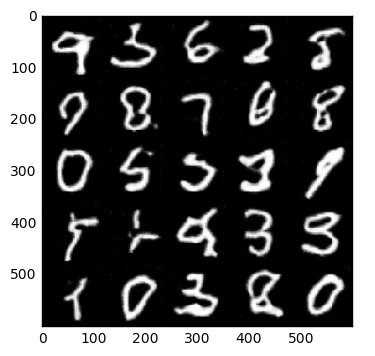

[Epoch 035] learning_rate: 0.000091, loss_fake: 0.655, loss_real: 0.664, loss_gen: 0.764


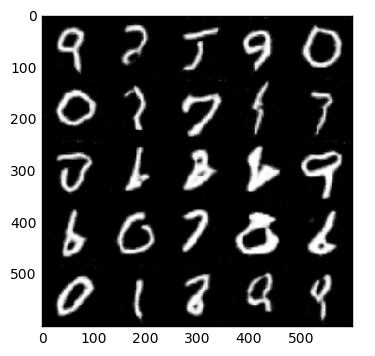

[Epoch 036] learning_rate: 0.000088, loss_fake: 0.661, loss_real: 0.666, loss_gen: 0.767


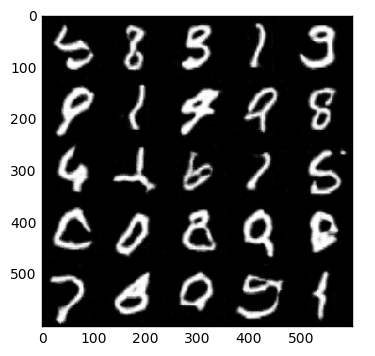

[Epoch 037] learning_rate: 0.000085, loss_fake: 0.666, loss_real: 0.668, loss_gen: 0.756


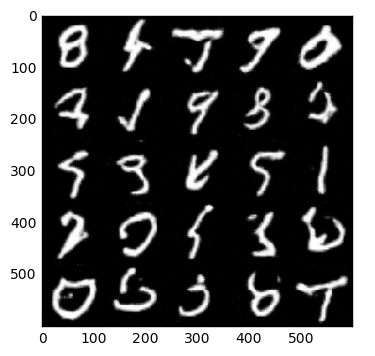

[Epoch 038] learning_rate: 0.000082, loss_fake: 0.677, loss_real: 0.674, loss_gen: 0.756


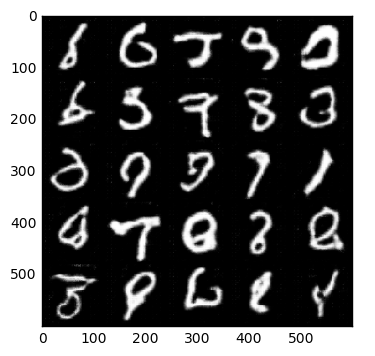

[Epoch 039] learning_rate: 0.000079, loss_fake: 0.669, loss_real: 0.680, loss_gen: 0.744


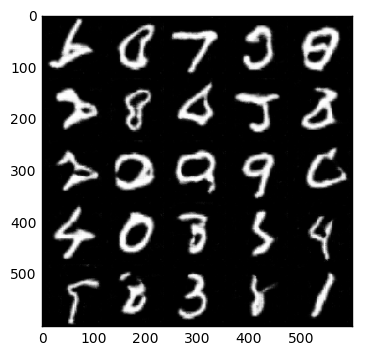

[Epoch 040] learning_rate: 0.000077, loss_fake: 0.665, loss_real: 0.666, loss_gen: 0.756


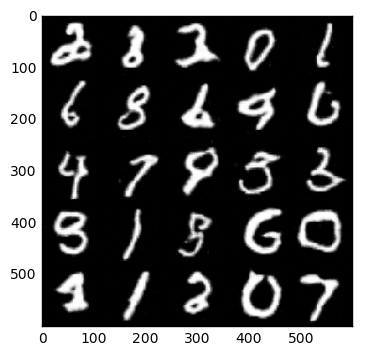

KeyboardInterrupt: 

In [9]:
train_dcgan_mnist64(
    output_dir='./tensorboard',  # >> tensorboard --logdir "./tensorboard"
    learning_rate_0=-3.5, 
    learning_rate_end=-5, 
    batch_size=64, 
    n_epochs=100, 
    iterations_per_epoch=50, 
    z_size=100, 
    g_size=64, 
    update_discriminator_times=1, 
    update_generator_times=3, 
    load_model_path='./tensorboard/20170129183030_mnist64_jupyter' 
)